# Libraries

In [1]:
## Python
import os
import time
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.callbacks import TensorBoard


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

Using TensorFlow backend.


### Global

In [55]:
from kaymo.configs import Config

emotions_dict = Config.EMOTION_DICT
DATA_PATH = os.path.abspath(Config.KayMODB_DATA_PATH)
PREPARED_PATH = os.path.abspath(Config.KayMODB_PREPARED_PATH)
MODEL_PATH = os.path.abspath(Config.KayMODB_MODELS_PATH)
print(DATA_PATH, PREPARED_PATH, MODEL_PATH)

AttributeError: type object 'Config' has no attribute 'KayMODB_MODELS_PATH'

# Reading the data

In [3]:
dir_list = os.listdir(DATA_PATH)
dir_list.sort()
print (dir_list)

['angry', 'bored', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [4]:
f'{PREPARED_PATH}/original_df.csv'

'/home/amr/Desktop/Speech-Recognition/kaymo/kaymo/data/KayMoDB_Prepared/original_df.csv'

In [50]:
data_df = pd.DataFrame(columns=['path', 'emotion', 'emotion_label'])

count = 0
for emotion_dir in dir_list:
    label = emotion_dir
    emotion = emotions_dict[label]
    file_list = os.listdir(DATA_PATH + '/' + emotion_dir)
#     print('emotion_dir: ', emotion_dir, 'file_list: ', file_list)
    for file in file_list:
        path = os.path.join(DATA_PATH + '/' + emotion_dir + '/', file)
#         print(path)
        data_df.loc[count] = [path, emotion, label]
        count += 1

In [51]:
# save to csv
data_df.to_csv(f'{PREPARED_PATH}/original_df.csv', index=None)

In [5]:
data_df = pd.read_csv(f'{PREPARED_PATH}/original_df.csv')

In [6]:
print (len(data_df))
data_df.head()

3107


path  emotion emotion_label
0  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        0         angry
1  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        0         angry
2  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        0         angry
3  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        0         angry
4  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        0         angry

# Plotting the audio file's waveform and its spectrogram

In [7]:
filename = data_df.path[random.randint(0, len(data_df))]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

/home/amr/Desktop/Speech-Recognition/kaymo/kaymo/data/KayMoDB/fearful/14a04Aa.wav


(22050, array([-1.8240266e-03, -2.3986548e-03, -2.0253316e-03, ...,
        -8.2221057e-05, -3.9495819e-05,  0.0000000e+00], dtype=float32))

In [8]:
len(samples), sample_rate

(32568, 22050)

In [9]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [10]:
sample_rate/ len(samples)

0.6770449521002211

### Plotting Wave Form and Spectrogram

Text(0.5, 0, 'Seconds')

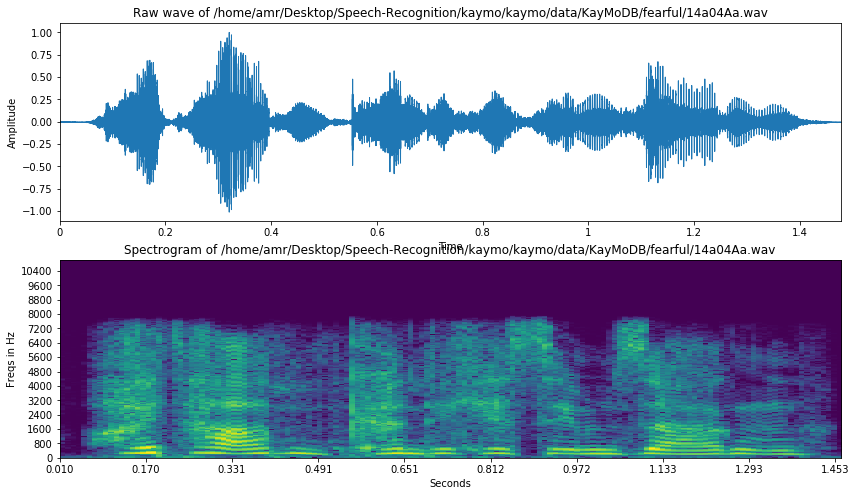

In [11]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [12]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

### Trim the silence voice

In [13]:
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-0.00148207, -0.0015702 , -0.00196777, ..., -0.00113684,
        -0.00097205, -0.0010138 ], dtype=float32), array([ 1024, 32256]))

### Plotting Mel Power Spectrogram

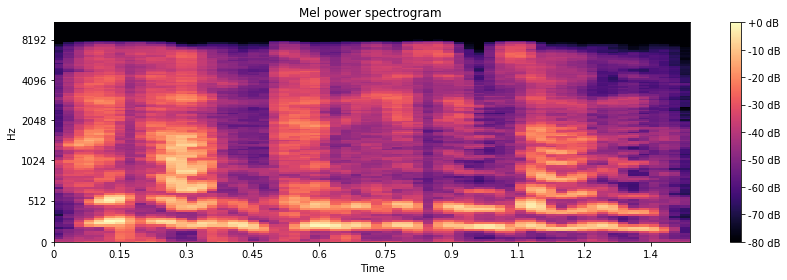

In [14]:
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

### Plotting MFCC

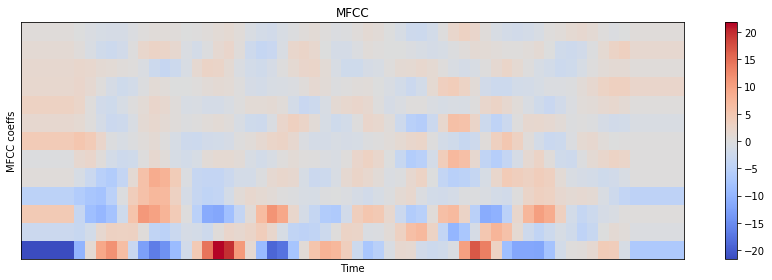

In [15]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

### Original Sound

In [16]:
ipd.Audio(samples, rate=sample_rate)

### Silence trimmed Sound by librosa.effects.trim()

In [17]:
ipd.Audio(aa, rate=sample_rate)

### Silence trimmed Sound by manuel trimming

In [18]:
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

### Plotting the emotion distribution

In [19]:
def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

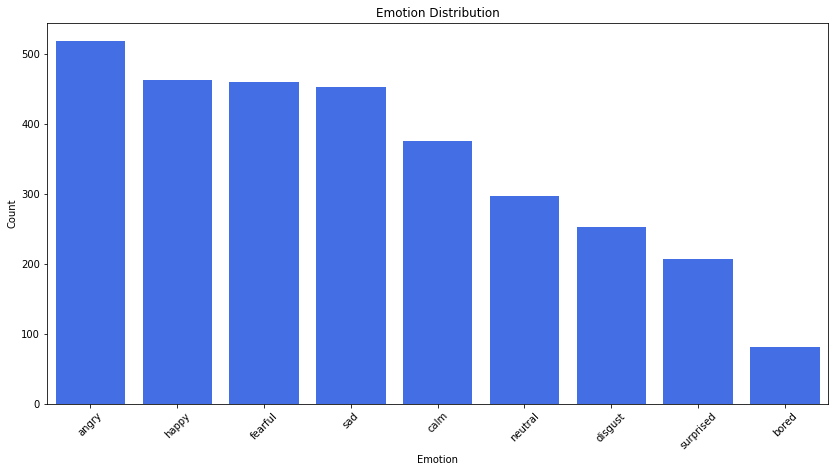

In [20]:
emotion_labels = data_df.emotion_label.value_counts()
plot_emotion_dist(emotion_labels, "#2962FF", "Emotion Distribution")

In [64]:
data_test_df = data_df.sample(frac = 0.3)
data_test_df.head()

path  emotion emotion_label
321   /home/amr/Desktop/Speech-Recognition/kaymo/kay...        0         angry
1297  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        4       fearful
2670  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        7           sad
2515  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        7           sad
1405  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        4       fearful

## Getting the features of audio files using librosa

In [68]:
data = pd.DataFrame(columns=['feature'])

In [69]:
for i in tqdm(range(len(data_df))):
#     print(data_df.path[i])
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast', 
                                  duration=input_duration, sr=22050*2, offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 3107/3107 [07:20<00:00,  5.84it/s]


In [70]:
data.head()

feature
0  [-51.86904745370218, -52.17249982286615, -52.4...
1  [-30.32068388026876, -31.572345352539063, -30....
2  [-54.44547796834759, -52.05779934425818, -49.1...
3  [-4.813129971882348, -9.508691508175342, -23.0...
4  [-55.586416926605, -51.791567999117675, -51.29...

In [71]:
df3 = pd.DataFrame(data['feature'].values.tolist())
emotion_labels = data_df.emotion_label

In [72]:
df3.head()

0          1          2          3          4          5    \
0 -51.869047 -52.172500 -52.459898 -52.298734 -51.766712 -51.786517   
1 -30.320684 -31.572345 -30.498347 -28.148847 -27.459323 -25.443995   
2 -54.445478 -52.057799 -49.102191 -51.636862 -53.023717 -50.265006   
3  -4.813130  -9.508692 -23.007471 -28.395273 -27.763023 -27.507332   
4 -55.586417 -51.791568 -51.292294 -54.289072 -58.340047 -57.043248   

         6          7          8          9    ...        249        250  \
0 -51.769278 -51.823124 -51.851056 -51.879569  ... -51.341266 -51.466054   
1 -21.067855 -13.067035 -12.702665 -17.345724  ... -30.828923 -29.859441   
2 -51.763048 -50.891198 -49.630251 -52.628661  ... -51.259474 -51.876838   
3 -26.203976 -28.170642 -31.419204 -31.620900  ...        NaN        NaN   
4 -55.121407 -54.930332 -55.360519 -55.143164  ... -41.550582 -40.839304   

         251        252        253        254        255        256  \
0 -50.450331 -51.070807 -50.461516 -50.993913 -51.434035 -51.362233   
1 -30.743330 -32.000932 -32.938201        NaN        NaN        NaN   
2 -50.504457 -49.666671 -47.161988 -42.707182 -41.740264 -43.264117   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4 -39.796597 -38.554192 -39.542313 -41.856510 -43.022509 -44.319129   

         257        258  
0 -50.276123 -49.933274  
1        NaN        NaN  
2 -36.410357 -29.679565  
3        NaN        NaN  
4 -44.491016 -42.153264  

[5 rows x 259 columns]

In [73]:
newdf = pd.concat([df3, emotion_labels], axis=1)

In [74]:
newdf.head(10)

0          1          2          3          4          5  \
0 -51.869047 -52.172500 -52.459898 -52.298734 -51.766712 -51.786517   
1 -30.320684 -31.572345 -30.498347 -28.148847 -27.459323 -25.443995   
2 -54.445478 -52.057799 -49.102191 -51.636862 -53.023717 -50.265006   
3  -4.813130  -9.508692 -23.007471 -28.395273 -27.763023 -27.507332   
4 -55.586417 -51.791568 -51.292294 -54.289072 -58.340047 -57.043248   
5 -43.951510 -44.841542 -45.650490 -43.158546 -43.397457 -44.986240   
6 -43.227067 -43.200322 -43.508201 -42.955101 -43.857461 -46.020665   
7  -9.140148  -8.505948  -9.381351 -10.109431 -10.248058 -10.669661   
8 -57.527229 -56.894404 -56.256938 -57.379610 -58.494613 -58.286768   
9 -43.426641 -43.430035 -43.430035 -43.430035 -43.430035 -43.430035   

           6          7          8          9  ...        250        251  \
0 -51.769278 -51.823124 -51.851056 -51.879569  ... -51.466054 -50.450331   
1 -21.067855 -13.067035 -12.702665 -17.345724  ... -29.859441 -30.743330   
2 -51.763048 -50.891198 -49.630251 -52.628661  ... -51.876838 -50.504457   
3 -26.203976 -28.170642 -31.419204 -31.620900  ...        NaN        NaN   
4 -55.121407 -54.930332 -55.360519 -55.143164  ... -40.839304 -39.796597   
5 -43.908142 -42.373390 -40.076611 -40.046149  ... -38.102465 -38.219192   
6 -46.020665 -46.020665 -45.124082 -44.270464  ... -44.174313 -44.373617   
7 -11.604359 -12.002146 -12.286555 -14.177439  ... -20.761182 -21.692991   
8 -57.229652 -55.460912 -54.526665 -54.932347  ... -47.156788 -45.804550   
9 -43.430035 -43.430035 -43.430035 -43.430035  ... -34.582296 -32.607094   

         252        253        254        255        256        257  \
0 -51.070807 -50.461516 -50.993913 -51.434035 -51.362233 -50.276123   
1 -32.000932 -32.938201        NaN        NaN        NaN        NaN   
2 -49.666671 -47.161988 -42.707182 -41.740264 -43.264117 -36.410357   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4 -38.554192 -39.542313 -41.856510 -43.022509 -44.319129 -44.491016   
5 -38.437847 -35.937061 -33.011924 -32.331395 -33.756927 -20.420326   
6 -43.544989 -43.921138 -44.418723 -43.965485 -45.192990 -44.320365   
7 -23.626239 -23.173347 -21.914357 -20.780074 -22.094121 -23.742670   
8 -46.703007 -44.535008 -44.923530 -45.820068 -45.104054 -46.700743   
9 -31.724126 -28.479787 -28.063536 -29.031501 -28.100177 -25.233667   

         258  emotion_label  
0 -49.933274          angry  
1        NaN          angry  
2 -29.679565          angry  
3        NaN          angry  
4 -42.153264          angry  
5 -13.134913          angry  
6 -43.644185          angry  
7 -24.475264          angry  
8 -47.835202          angry  
9 -18.876830          angry  

[10 rows x 260 columns]

In [75]:
rnewdf = newdf.rename(index=str, columns={"0": "emotion_label"})
len(rnewdf)

3107

In [76]:
rnewdf.head(10)

0          1          2          3          4          5  \
0 -51.869047 -52.172500 -52.459898 -52.298734 -51.766712 -51.786517   
1 -30.320684 -31.572345 -30.498347 -28.148847 -27.459323 -25.443995   
2 -54.445478 -52.057799 -49.102191 -51.636862 -53.023717 -50.265006   
3  -4.813130  -9.508692 -23.007471 -28.395273 -27.763023 -27.507332   
4 -55.586417 -51.791568 -51.292294 -54.289072 -58.340047 -57.043248   
5 -43.951510 -44.841542 -45.650490 -43.158546 -43.397457 -44.986240   
6 -43.227067 -43.200322 -43.508201 -42.955101 -43.857461 -46.020665   
7  -9.140148  -8.505948  -9.381351 -10.109431 -10.248058 -10.669661   
8 -57.527229 -56.894404 -56.256938 -57.379610 -58.494613 -58.286768   
9 -43.426641 -43.430035 -43.430035 -43.430035 -43.430035 -43.430035   

           6          7          8          9  ...        250        251  \
0 -51.769278 -51.823124 -51.851056 -51.879569  ... -51.466054 -50.450331   
1 -21.067855 -13.067035 -12.702665 -17.345724  ... -29.859441 -30.743330   
2 -51.763048 -50.891198 -49.630251 -52.628661  ... -51.876838 -50.504457   
3 -26.203976 -28.170642 -31.419204 -31.620900  ...        NaN        NaN   
4 -55.121407 -54.930332 -55.360519 -55.143164  ... -40.839304 -39.796597   
5 -43.908142 -42.373390 -40.076611 -40.046149  ... -38.102465 -38.219192   
6 -46.020665 -46.020665 -45.124082 -44.270464  ... -44.174313 -44.373617   
7 -11.604359 -12.002146 -12.286555 -14.177439  ... -20.761182 -21.692991   
8 -57.229652 -55.460912 -54.526665 -54.932347  ... -47.156788 -45.804550   
9 -43.430035 -43.430035 -43.430035 -43.430035  ... -34.582296 -32.607094   

         252        253        254        255        256        257  \
0 -51.070807 -50.461516 -50.993913 -51.434035 -51.362233 -50.276123   
1 -32.000932 -32.938201        NaN        NaN        NaN        NaN   
2 -49.666671 -47.161988 -42.707182 -41.740264 -43.264117 -36.410357   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4 -38.554192 -39.542313 -41.856510 -43.022509 -44.319129 -44.491016   
5 -38.437847 -35.937061 -33.011924 -32.331395 -33.756927 -20.420326   
6 -43.544989 -43.921138 -44.418723 -43.965485 -45.192990 -44.320365   
7 -23.626239 -23.173347 -21.914357 -20.780074 -22.094121 -23.742670   
8 -46.703007 -44.535008 -44.923530 -45.820068 -45.104054 -46.700743   
9 -31.724126 -28.479787 -28.063536 -29.031501 -28.100177 -25.233667   

         258  emotion_label  
0 -49.933274          angry  
1        NaN          angry  
2 -29.679565          angry  
3        NaN          angry  
4 -42.153264          angry  
5 -13.134913          angry  
6 -43.644185          angry  
7 -24.475264          angry  
8 -47.835202          angry  
9 -18.876830          angry  

[10 rows x 260 columns]

In [77]:
rnewdf.isnull().sum().sum()

49363

In [78]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

0          1          2          3          4          5  \
0 -51.869047 -52.172500 -52.459898 -52.298734 -51.766712 -51.786517   
1 -30.320684 -31.572345 -30.498347 -28.148847 -27.459323 -25.443995   
2 -54.445478 -52.057799 -49.102191 -51.636862 -53.023717 -50.265006   
3  -4.813130  -9.508692 -23.007471 -28.395273 -27.763023 -27.507332   
4 -55.586417 -51.791568 -51.292294 -54.289072 -58.340047 -57.043248   

           6          7          8          9  ...        250        251  \
0 -51.769278 -51.823124 -51.851056 -51.879569  ... -51.466054 -50.450331   
1 -21.067855 -13.067035 -12.702665 -17.345724  ... -29.859441 -30.743330   
2 -51.763048 -50.891198 -49.630251 -52.628661  ... -51.876838 -50.504457   
3 -26.203976 -28.170642 -31.419204 -31.620900  ...   0.000000   0.000000   
4 -55.121407 -54.930332 -55.360519 -55.143164  ... -40.839304 -39.796597   

         252        253        254        255        256        257  \
0 -51.070807 -50.461516 -50.993913 -51.434035 -51.362233 -50.276123   
1 -32.000932 -32.938201   0.000000   0.000000   0.000000   0.000000   
2 -49.666671 -47.161988 -42.707182 -41.740264 -43.264117 -36.410357   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4 -38.554192 -39.542313 -41.856510 -43.022509 -44.319129 -44.491016   

         258  emotion_label  
0 -49.933274          angry  
1   0.000000          angry  
2 -29.679565          angry  
3   0.000000          angry  
4 -42.153264          angry  

[5 rows x 260 columns]

In [79]:
# save to csv
rnewdf.to_csv(f'{PREPARED_PATH}/features_of_audio_data.csv', index=None)

In [80]:
rnewdf.head()

0          1          2          3          4          5  \
0 -51.869047 -52.172500 -52.459898 -52.298734 -51.766712 -51.786517   
1 -30.320684 -31.572345 -30.498347 -28.148847 -27.459323 -25.443995   
2 -54.445478 -52.057799 -49.102191 -51.636862 -53.023717 -50.265006   
3  -4.813130  -9.508692 -23.007471 -28.395273 -27.763023 -27.507332   
4 -55.586417 -51.791568 -51.292294 -54.289072 -58.340047 -57.043248   

           6          7          8          9  ...        250        251  \
0 -51.769278 -51.823124 -51.851056 -51.879569  ... -51.466054 -50.450331   
1 -21.067855 -13.067035 -12.702665 -17.345724  ... -29.859441 -30.743330   
2 -51.763048 -50.891198 -49.630251 -52.628661  ... -51.876838 -50.504457   
3 -26.203976 -28.170642 -31.419204 -31.620900  ...   0.000000   0.000000   
4 -55.121407 -54.930332 -55.360519 -55.143164  ... -40.839304 -39.796597   

         252        253        254        255        256        257  \
0 -51.070807 -50.461516 -50.993913 -51.434035 -51.362233 -50.276123   
1 -32.000932 -32.938201   0.000000   0.000000   0.000000   0.000000   
2 -49.666671 -47.161988 -42.707182 -41.740264 -43.264117 -36.410357   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4 -38.554192 -39.542313 -41.856510 -43.022509 -44.319129 -44.491016   

         258  emotion_label  
0 -49.933274          angry  
1   0.000000          angry  
2 -29.679565          angry  
3   0.000000          angry  
4 -42.153264          angry  

[5 rows x 260 columns]

In [21]:
# read from csv
rnewdf_test = pd.read_csv(f'{PREPARED_PATH}/features_of_audio_data.csv')

In [22]:
rnewdf_test.head()

0          1          2          3          4          5  \
0 -51.869047 -52.172500 -52.459898 -52.298734 -51.766712 -51.786517   
1 -30.320684 -31.572345 -30.498347 -28.148847 -27.459323 -25.443995   
2 -54.445478 -52.057799 -49.102191 -51.636862 -53.023717 -50.265006   
3  -4.813130  -9.508692 -23.007471 -28.395273 -27.763023 -27.507332   
4 -55.586417 -51.791568 -51.292294 -54.289072 -58.340047 -57.043248   

           6          7          8          9  ...        250        251  \
0 -51.769278 -51.823124 -51.851056 -51.879569  ... -51.466054 -50.450331   
1 -21.067855 -13.067035 -12.702665 -17.345724  ... -29.859441 -30.743330   
2 -51.763048 -50.891198 -49.630251 -52.628661  ... -51.876838 -50.504457   
3 -26.203976 -28.170642 -31.419204 -31.620900  ...   0.000000   0.000000   
4 -55.121407 -54.930332 -55.360519 -55.143164  ... -40.839304 -39.796597   

         252        253        254        255        256        257  \
0 -51.070807 -50.461516 -50.993913 -51.434035 -51.362233 -50.276123   
1 -32.000932 -32.938201   0.000000   0.000000   0.000000   0.000000   
2 -49.666671 -47.161988 -42.707182 -41.740264 -43.264117 -36.410357   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4 -38.554192 -39.542313 -41.856510 -43.022509 -44.319129 -44.491016   

         258  emotion_label  
0 -49.933274          angry  
1   0.000000          angry  
2 -29.679565          angry  
3   0.000000          angry  
4 -42.153264          angry  

[5 rows x 260 columns]

## Data Augmentation

In [23]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

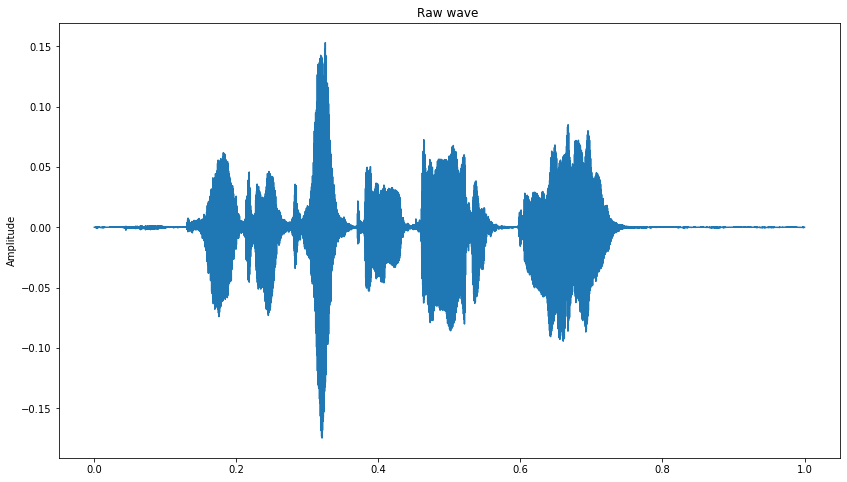

In [24]:
X, sample_rate = librosa.load(data_df.path[2000], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

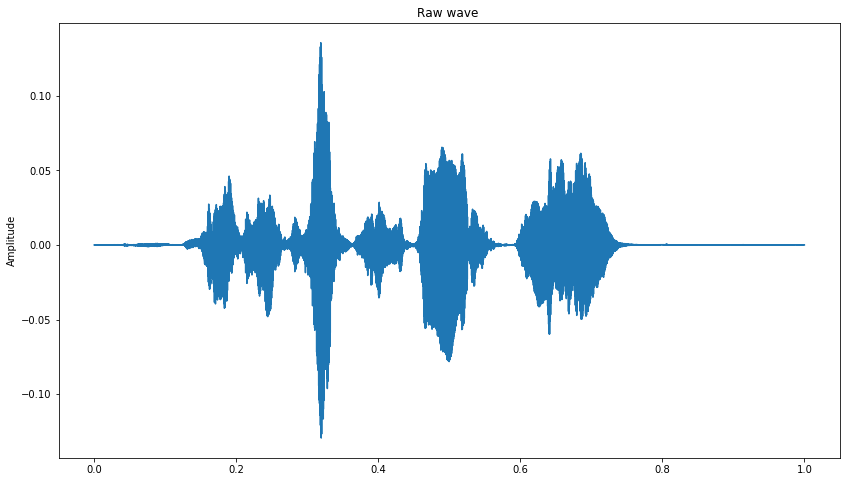

In [25]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

### Augmentation Method 1

In [86]:
syn_data1 = pd.DataFrame(columns=['feature', 'emotion_label'])
for i in tqdm(range(len(data_df))):
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',
                                  duration = input_duration, sr = 22050*2, offset = 0.5)
    if data_df.emotion_label[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data_df.emotion_label[i]]

100%|██████████| 3107/3107 [09:30<00:00,  5.71it/s]


### Augmentation Method 2

In [89]:
syn_data2 = pd.DataFrame(columns=['feature', 'emotion_label'])
for i in tqdm(range(len(data_df))):
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data_df.emotion_label[i]:
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data_df.emotion_label[i]]

100%|██████████| 3107/3107 [19:34<00:00,  2.54it/s]


In [91]:
len(syn_data1), len(syn_data2)

(3107, 3107)

In [92]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [93]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.emotion_label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "emotion_label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

3107

In [94]:
syndf1.head()

0          1          2          3          4          5  \
0 -41.933058 -43.151716 -46.540787 -45.642903 -45.007246 -44.722610   
1 -25.875916 -26.553720 -26.956216 -27.243861 -25.291588 -25.253334   
2 -54.448165 -51.915352 -49.140431 -51.570462 -52.905475 -50.243296   
3  -4.592922  -9.042429 -22.147327 -25.729497 -23.359393 -21.941619   
4 -55.216845 -51.354348 -51.133952 -54.202951 -58.452915 -57.256704   

           6          7          8          9  ...        250        251  \
0 -44.611262 -42.991251 -44.518543 -45.473923  ... -44.051393 -43.904441   
1 -20.306007 -12.379021 -12.082395 -16.862739  ... -27.604762 -27.750042   
2 -51.835013 -50.953699 -49.581352 -52.434610  ... -51.927942 -50.501881   
3 -20.896289 -22.497767 -23.238446 -23.178380  ...   0.000000   0.000000   
4 -55.207251 -54.772426 -55.356917 -55.218556  ... -40.876512 -39.749928   

         252        253        254        255        256        257  \
0 -44.205805 -44.596624 -45.156096 -42.565804 -42.678135 -41.795782   
1 -29.612484 -29.509030   0.000000   0.000000   0.000000   0.000000   
2 -49.523595 -47.052342 -42.749638 -41.822102 -43.331844 -36.382825   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4 -38.455005 -39.484163 -41.792995 -42.902908 -44.223746 -44.438115   

         258  emotion_label  
0 -43.122627          angry  
1   0.000000          angry  
2 -29.655291          angry  
3   0.000000          angry  
4 -42.069662          angry  

[5 rows x 260 columns]

In [95]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.emotion_label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "emotion_label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

3107

In [96]:
syndf2.head()

0          1          2          3          4          5  \
0 -52.188372 -52.494484 -52.521716 -52.337335 -52.240228 -52.069659   
1 -31.006006 -31.744296 -32.635754 -31.065117 -28.175803 -25.066528   
2 -55.319760 -54.599822 -51.968164 -52.221474 -55.245436 -53.581233   
3  -5.463021 -10.102027 -25.885929 -31.089775 -30.415322 -26.471952   
4 -55.806635 -54.089865 -53.083432 -55.877941 -59.251061 -60.343475   

           6          7          8          9  ...        250        251  \
0 -52.067390 -52.096538 -52.131640 -52.147051  ... -51.695239 -51.445286   
1 -21.768426 -17.398480 -16.802670 -19.989052  ... -32.771880 -32.122558   
2 -53.512749 -52.312517 -53.080655 -54.961811  ... -53.620267 -53.506711   
3 -28.735483 -31.341337 -33.591818 -36.176621  ...   0.000000   0.000000   
4 -60.836172 -59.991291 -58.876560 -59.368669  ... -46.888329 -45.301833   

         252        253        254        255        256        257  \
0 -51.417129 -51.549748 -51.274142 -51.892214 -51.428699 -51.219244   
1 -34.679836 -37.731939   0.000000   0.000000   0.000000   0.000000   
2 -52.822978 -47.170205 -46.261960 -47.609985 -44.371020 -41.438937   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4 -45.783843 -45.616400 -47.760926 -48.971737 -49.765469 -48.299804   

         258  emotion_label  
0 -51.324789          angry  
1   0.000000          angry  
2 -42.173915          angry  
3   0.000000          angry  
4 -46.783326          angry  

[5 rows x 260 columns]

In [97]:
# save to csv
syndf1.to_csv(f'{PREPARED_PATH}/augmented_data_with_noise_list.csv', index=None)

In [98]:
syndf1.head()

0          1          2          3          4          5  \
0 -41.933058 -43.151716 -46.540787 -45.642903 -45.007246 -44.722610   
1 -25.875916 -26.553720 -26.956216 -27.243861 -25.291588 -25.253334   
2 -54.448165 -51.915352 -49.140431 -51.570462 -52.905475 -50.243296   
3  -4.592922  -9.042429 -22.147327 -25.729497 -23.359393 -21.941619   
4 -55.216845 -51.354348 -51.133952 -54.202951 -58.452915 -57.256704   

           6          7          8          9  ...        250        251  \
0 -44.611262 -42.991251 -44.518543 -45.473923  ... -44.051393 -43.904441   
1 -20.306007 -12.379021 -12.082395 -16.862739  ... -27.604762 -27.750042   
2 -51.835013 -50.953699 -49.581352 -52.434610  ... -51.927942 -50.501881   
3 -20.896289 -22.497767 -23.238446 -23.178380  ...   0.000000   0.000000   
4 -55.207251 -54.772426 -55.356917 -55.218556  ... -40.876512 -39.749928   

         252        253        254        255        256        257  \
0 -44.205805 -44.596624 -45.156096 -42.565804 -42.678135 -41.795782   
1 -29.612484 -29.509030   0.000000   0.000000   0.000000   0.000000   
2 -49.523595 -47.052342 -42.749638 -41.822102 -43.331844 -36.382825   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4 -38.455005 -39.484163 -41.792995 -42.902908 -44.223746 -44.438115   

         258  emotion_label  
0 -43.122627          angry  
1   0.000000          angry  
2 -29.655291          angry  
3   0.000000          angry  
4 -42.069662          angry  

[5 rows x 260 columns]

In [26]:
# read from csv
# syndf1_test = pd.read_csv(f'{PREPARED_PATH}/augmented_data_with_noise_list.csv')
syndf1 = pd.read_csv(f'{PREPARED_PATH}/augmented_data_with_noise_list.csv')

In [99]:
# save to csv
syndf2.to_csv(f'{PREPARED_PATH}/augmented_data_with_pitch_list.csv', index=None)

In [27]:
# read from csv
# syndf2_test = pd.read_csv(f'{PREPARED_PATH}/augmented_data_with_pitch_list.csv')
syndf2 = pd.read_csv(f'{PREPARED_PATH}/augmented_data_with_pitch_list.csv')

### Combining the Augmented data with original

In [28]:
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

NameError: name 'rnewdf' is not defined

In [101]:
# save to csv
combined_df.to_csv(f'{PREPARED_PATH}/combined_augmented_data.csv', index=None)

In [29]:
# read from csv
# combined_df_test = pd.read_csv(f'{PREPARED_PATH}/combined_augmented_data.csv')
combined_df = pd.read_csv(f'{PREPARED_PATH}/combined_augmented_data.csv')

### Stratified Shuffle Split

In [30]:
X = combined_df.drop(['emotion_label'], axis=1)
y = combined_df.emotion_label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [31]:
y_train.value_counts()

angry        1243
happy        1109
fearful      1104
sad          1087
calm          902
neutral       713
disgust       607
surprised     497
bored         194
Name: emotion_label, dtype: int64

In [32]:
y_test.value_counts()

angry        311
happy        277
fearful      276
sad          272
calm         226
neutral      178
disgust      152
surprised    124
bored         49
Name: emotion_label, dtype: int64

In [33]:
X_train.isna().sum().sum()

0

#### numpify & to_categorical

In [34]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [35]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [36]:
X_train.shape

(7456, 259)

## CNN model

In [37]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

#### Set up Keras util functions

In [38]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [39]:
print(Config.KayMODB_CLASS_LABELS)
print(len(Config.KayMODB_CLASS_LABELS))

('angry', 'bored', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised')
9


In [40]:
model = Sequential()

model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1], 1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=(8)))

model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling1D(pool_size=(8)))

model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(len(Config.KayMODB_CLASS_LABELS))) # target class no.
model.add(Activation('softmax'))

opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Plotting model summary

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 259, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 256)           0         
__________

In [42]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [43]:
# Create a TensorBoard instance with the path to the logs directory
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', write_graph=True)
tensorboard.set_model(model) 

### Model training

In [44]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)

mcp_save = ModelCheckpoint('/home/amr/Desktop/Speech-Recognition/kaymo/kaymo/models/pretrained/new_cnn_kaymodb.h5', save_best_only=True, monitor='val_loss', mode='min')


In [ ]:
cnn_history=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[tensorboard, mcp_save, lr_reduce])

### Plotting the Train Valid Loss Graph

In [ ]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Saving the model

In [56]:
MODEL_PATH = os.path.abspath('./kaymo/models/pretrained/')
print(MODEL_PATH)

/home/amr/Desktop/Speech-Recognition/kaymo/kaymo/models/pretrained


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [57]:
from keras.models import model_from_json
json_file = open(f'{MODEL_PATH}/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(f'{MODEL_PATH}/new_cnn_kaymodb.h5')
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 91.64%


## Predicting emotions on the test data

In [65]:
len(data_test_df)

932

In [75]:
data_test_df.index = range(len(data_test_df))

In [76]:
data_test_df.head()

path  emotion emotion_label
0  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        0         angry
1  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        4       fearful
2  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        7           sad
3  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        7           sad
4  /home/amr/Desktop/Speech-Recognition/kaymo/kay...        4       fearful

In [77]:
data_test = pd.DataFrame(columns=['feature'])

In [78]:
for i in tqdm(range(len(data_test_df))):
#     print(data_test_df.path[i])
    X, sample_rate = librosa.load(data_test_df.path[i], res_type='kaiser_fast', 
                                  duration=input_duration, sr=22050*2, offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]

100%|██████████| 932/932 [02:43<00:00,  5.76it/s]


In [80]:
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data_test_df.emotion_label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

In [82]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

932/932 [==============================] - 2s 2ms/step


In [83]:
preds

array([[9.8762149e-01, 5.6550460e-05, 4.0703948e-04, ..., 1.0208515e-03,
        7.7496523e-05, 2.3911527e-06],
       [2.8964452e-05, 8.9267637e-08, 1.1718336e-10, ..., 1.4731948e-08,
        8.0105046e-06, 4.3242064e-05],
       [4.6976138e-06, 2.6622796e-04, 4.4166655e-03, ..., 2.5238068e-04,
        9.6956664e-01, 2.1487553e-05],
       ...,
       [9.9844402e-01, 6.4049304e-06, 7.4981515e-05, ..., 5.8126776e-04,
        1.1823814e-05, 4.2920160e-06],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [9.7936732e-01, 1.3193703e-04, 7.6440684e-03, ..., 3.4645275e-04,
        6.4969592e-04, 2.3491714e-04]], dtype=float32)

In [84]:
preds1=preds.argmax(axis=1)
preds1

array([0, 4, 7, 7, 4, 0, 1, 3, 6, 0, 0, 4, 7, 4, 0, 5, 0, 7, 2, 7, 2, 7,
       0, 4, 5, 2, 0, 2, 7, 2, 5, 8, 8, 0, 3, 7, 2, 3, 0, 0, 5, 3, 0, 8,
       7, 2, 3, 0, 2, 7, 8, 2, 0, 5, 0, 7, 0, 5, 6, 4, 6, 2, 0, 0, 6, 0,
       0, 0, 0, 5, 7, 5, 0, 5, 5, 0, 0, 3, 4, 7, 3, 0, 0, 4, 4, 0, 2, 0,
       3, 0, 7, 7, 0, 7, 0, 0, 0, 7, 2, 0, 5, 0, 0, 2, 0, 0, 0, 0, 5, 7,
       0, 6, 4, 6, 3, 0, 4, 4, 5, 6, 4, 2, 0, 4, 0, 0, 4, 0, 2, 2, 6, 4,
       3, 7, 0, 0, 0, 2, 0, 0, 0, 0, 7, 7, 0, 0, 6, 6, 6, 2, 0, 2, 7, 4,
       0, 0, 7, 0, 0, 4, 2, 7, 4, 4, 4, 0, 0, 3, 0, 5, 0, 4, 5, 8, 2, 7,
       2, 2, 0, 0, 5, 3, 0, 5, 0, 0, 0, 5, 8, 2, 0, 2, 0, 0, 4, 3, 0, 4,
       7, 7, 5, 7, 4, 0, 6, 5, 2, 4, 6, 0, 0, 7, 5, 0, 0, 0, 6, 0, 7, 6,
       3, 0, 4, 0, 0, 3, 5, 0, 5, 0, 0, 5, 4, 5, 0, 0, 5, 7, 7, 0, 1, 4,
       0, 0, 0, 2, 0, 8, 3, 7, 0, 5, 0, 7, 7, 6, 5, 7, 2, 2, 0, 5, 0, 3,
       7, 6, 0, 5, 2, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 5, 2, 4, 5, 2, 7,
       5, 8, 7, 2, 0, 0, 0, 7, 4, 5, 8, 0, 3, 4, 0,

In [86]:
abc = preds1.astype(int).flatten()

In [88]:
predictions = (lb.inverse_transform((abc)))

In [90]:
preddf = pd.DataFrame({'predicted_values': predictions})
preddf.head()

predicted_values
0            angry
1          fearful
2              sad
3              sad
4          fearful

In [91]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [92]:
actualdf = pd.DataFrame({'actual_values': actualvalues})
actualdf.head()

actual_values
0         angry
1       fearful
2           sad
3           sad
4       fearful

In [93]:
finaldf = actualdf.join(preddf)

In [94]:
finaldf[20:40]

actual_values predicted_values
20          calm             calm
21           sad              sad
22         angry            angry
23       fearful          fearful
24         happy            happy
25          calm             calm
26       neutral            angry
27          calm             calm
28           sad              sad
29          calm             calm
30         happy            happy
31     surprised        surprised
32     surprised        surprised
33       neutral            angry
34       disgust          disgust
35           sad              sad
36          calm             calm
37       disgust          disgust
38       fearful            angry
39         angry            angry

In [95]:
finaldf.groupby('actual_values').count()

predicted_values
actual_values                  
angry                       156
bored                        19
calm                        116
disgust                      75
fearful                     134
happy                       141
neutral                      79
sad                         148
surprised                    64

In [96]:
finaldf.groupby('predicted_values').count()

actual_values
predicted_values               
angry                       362
bored                         5
calm                        107
disgust                      59
fearful                      88
happy                       101
neutral                      55
sad                         121
surprised                    34

In [97]:
finaldf.to_csv(f'{PREPARED_PATH}Predictions.csv', index=False)

In [98]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [99]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actual_values
y_pred = finaldf.predicted_values
accuracy_score(y_true, y_pred)*100

77.14592274678111

In [100]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

75.72470252474298

In [101]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[156,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 14,   5,   0,   0,   0,   0,   0,   0,   0],
       [ 10,   0, 105,   0,   0,   0,   1,   0,   0],
       [ 17,   0,   1,  57,   0,   0,   0,   0,   0],
       [ 45,   0,   0,   1,  88,   0,   0,   0,   0],
       [ 40,   0,   0,   0,   0, 100,   1,   0,   0],
       [ 26,   0,   0,   0,   0,   0,  53,   0,   0],
       [ 24,   0,   1,   1,   0,   1,   0, 121,   0],
       [ 30,   0,   0,   0,   0,   0,   0,   0,  34]])

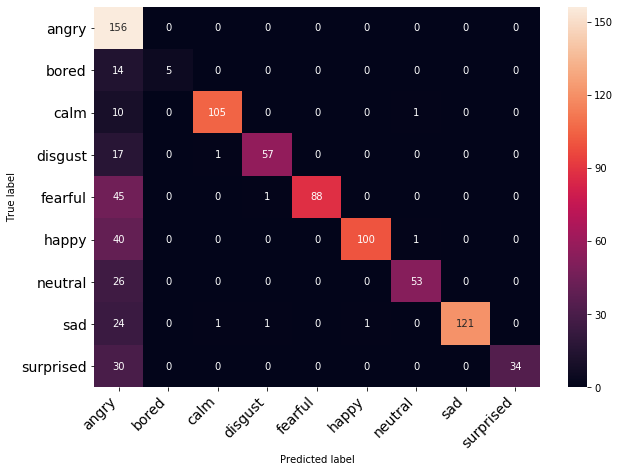

In [102]:
print_confusion_matrix(c, Config.KayMODB_CLASS_LABELS)

# Real-Time Testing

In [149]:
import numpy as np
import matplotlib.pyplot as plt

def draw_radar(data_prob):
    r"""
    Confidence Probability Radar Chart
    :param data_prob: probability array
    :param class_labels:
    :param num_classes:
    :return:
    """

    plt.clf()  # clear & refresh chart

    angles = np.linspace(0, 2 * np.pi, len(Config.KayMODB_CLASS_LABELS), endpoint=False)  # TODO: NUM_CLASSES FROM Configs
    data = np.concatenate((data_prob, [data_prob[0]]))
    angles = np.concatenate((angles, [angles[0]]))  # TODO: Check this again
    # print('data', data)
    # print('angles', angles)

    fig = plt.figure(1)

    # Polar parameters
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, data, 'bo-', linewidth=2)
    ax.fill(angles, data, facecolor='r', alpha=0.25)
    ax.set_thetagrids(angles * 180 / np.pi, Config.KayMODB_CLASS_LABELS)  # TODO: class_labels FROM Configs
    ax.set_title("Emotion Recognition", va='bottom')

    # Where a radar map data maximum
    ax.set_rlim(0, 1)
    ax.grid(True)

    plt.pause(1)  # pause time


In [105]:
!ls

2019_06_14_12_27_01.wav  file.wav	LICENSE     __pycache__  setup.py
2019_06_14_12_42_03.wav  german2.wav	logs	    README.md	 test
audio.py		 kaymo		main.py     run.py	 test.py
emodb.py		 KayMoDB.ipynb	output.wav  scripts	 XDG_CACHE_HOME


In [104]:
os.path.abspath('.')

'/home/amr/Desktop/Speech-Recognition/kaymo'

In [182]:
data_path = os.path.abspath('ywah.wav')
data_path

'/home/amr/Desktop/Speech-Recognition/kaymo/ywah.wav'

In [183]:
data_test = pd.DataFrame(columns=['feature'])

In [184]:
X, sample_rate = librosa.load(data_path, res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
original_sample_rate = sample_rate
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
feature = mfccs
data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid = np.expand_dims(test_valid, axis=2)

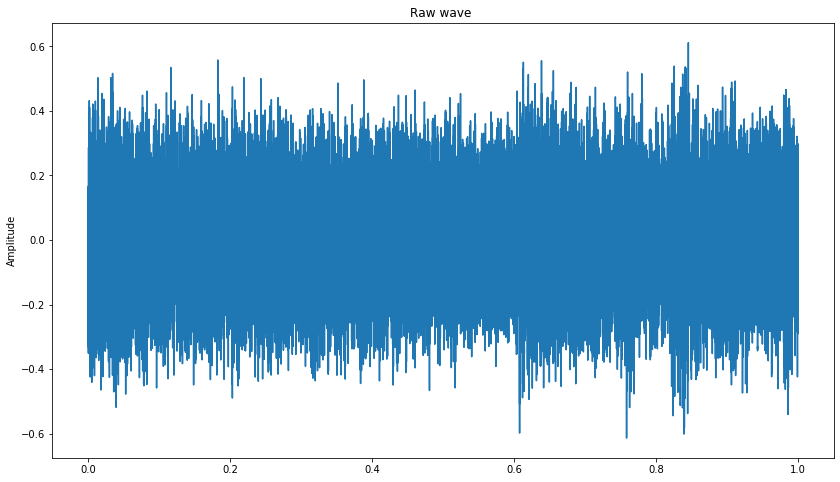

In [185]:
plot_time_series(X)
ipd.Audio(X, rate=original_sample_rate)

In [186]:
preds = loaded_model.predict(test_valid)

In [187]:
preds = preds.flatten()
preds

array([7.3907501e-04, 5.5054682e-01, 5.1386436e-05, 6.6519002e-03,
       1.5466490e-01, 8.2376525e-03, 2.0433243e-02, 2.5755933e-01,
       1.1157390e-03], dtype=float32)

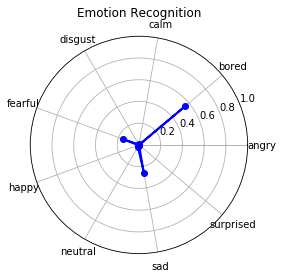

In [188]:
draw_radar(preds)

In [189]:
preds1=preds.argmax()
preds1

1

In [190]:
Config.KayMODB_CLASS_LABELS[preds1]

'bored'

In [146]:
import os
import wave
from datetime import datetime
from pyaudio import PyAudio, paInt16

class Audioer(object):

    def __init__(self):
        self.chunk = 1024  # num_samples
        self.channels = 1
        self.format = paInt16
        self.sampling_rate = 44100
        self.record_seconds = 5
        self.voice_string = []

        self.audio = PyAudio()

    def save_wave(self, filename):
        r"""
        Save the audio file
        :param filename:
        :return:
        """
        wf = wave.open(filename, 'wb')
        wf.setnchannels(self.channels)
        wf.setsampwidth(self.audio.get_sample_size(self.format))
        wf.setframerate(self.sampling_rate)
        # wf.writeframes(b''.join(self.voice_string))
        wf.writeframes(np.array(self.voice_string).tostring())
        wf.close()

    def record_audio(self):
        stream = self.audio.open(
            format=self.format,
            channels=self.channels,
            rate=self.sampling_rate,
            input=True,
            frames_per_buffer=self.chunk)

        print("Start Recording your voice...")

        for i in range(0, int(self.sampling_rate / self.chunk * self.record_seconds)):
            data = stream.read(self.chunk)
            self.voice_string.append(data)

        print("End of Record")
        stream.stop_stream()
        stream.close()
        self.audio.terminate()

        return True

In [147]:
def extract_features(data_path):
    data_test = pd.DataFrame(columns=['feature'])

    X, sample_rate = librosa.load(data_path, res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
    test_valid = pd.DataFrame(data_test['feature'].values.tolist())
    test_valid = np.array(test_valid)
    test_valid = np.expand_dims(test_valid, axis=2)
    
    return test_valid

Start Recording your voice...
End of Record
/home/amr/Desktop/Speech-Recognition/kaymo/2019_06_27_13_22_34.wav


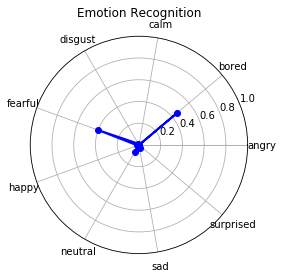

bored
Start Recording your voice...
End of Record
/home/amr/Desktop/Speech-Recognition/kaymo/2019_06_27_13_22_41.wav


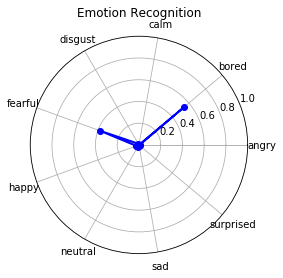

bored
Start Recording your voice...


KeyboardInterrupt: 

In [181]:
while True:
        rec = Audioer()
        audio = rec.record_audio()
        now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        filename = now + ".wav"
        rec.save_wave(filename)

        data_path = os.path.abspath(filename)
        
        print(data_path)
        preds = loaded_model.predict(
                    extract_features(data_path))
        preds = preds.flatten()
        draw_radar(preds)
        
        result = Config.KayMODB_CLASS_LABELS[preds.argmax()]
        
        print(result)
        
        os.remove(filename)

In [ ]:
preds = loaded_model.predict(
                    extract_features(data_test)
)

In [ ]:
result = Config.KayMODB_CLASS_LABELS[preds.argmax(axis=1)[0]]